# Etap 1
### autorzy
- Julia Jodczyk
- Filip Pawłowski

## Zadanie:
W ramach projektu wcielamy się w rolę analityka pracującego dla portalu„Pozytywka” – serwisu muzycznego, który swoim użytkownikom pozwala na odtwarzanie ulubionych utworów online. Praca na tym stanowisku nie jest łatwa –zadanie dostajemy w formie enigmatycznego opisu i to do nas należy doprecyzowanie szczegółów tak, aby dało się je zrealizować. To oczywiście wymaga  zrozumienia  problemu,  przeanalizowania  danych,  czasami  negocjacji  z  szefostwem. Same  modelemusimy skonstruowaćtak,  aby gotowe  były do  wdrożenia  produkcyjnego – pamiętając,  że  w  przyszłości  będą  pojawiać  się  kolejne  ich  wersje,z  którymi  będziemy eksperymentować.

“Jakiś czas temu wprowadziliśmy konta premium, które uwalniają użytkowników od słuchania reklam. Nie są one jednak jeszcze zbyt popularne – czy możemy się dowiedzieć, które osoby są bardziej skłonne do zakupu takiego konta?”

## Definicja problemu biznesowego
Z biznesowego punktu widzenia, chcemy móc identyfikować użytkowników skłonnych do zakupu konta premium, aby bardziej skupić się na tej grupie pod względem reklamowania kont premium. Proces identyfikacji powinien odbywać się w pewnych odstępach czasowych - być może zainteresowanie użytkowników kontem premium w zależności od różnych czynników się zmienia.

## Zadanie modelowania
Zadaniem modelowania będzie klasyfikacja binarna:
1. użytkownicy, którzy kupili konto premium
2. użytkonicy, którzy nie kupili konta premium.


## Założenia
- Dane będą analizowane w odstępach czasowych, które zdefiniujemy po analizie danych. Oznacza to, że jeśli użytkownik kupi konto premium w n-tym analizowanym okresie, to zostaje wykluczony z analizy w okresach następujących po nim.
- Głównym źródłem analizy będą historie sesji użytkowników (jak długo przebywają na platformie, z jaką częstotliwością wyświetlają się im reklamy, itp.).
- Pod uwagę weźmiemy również pozostałe cechy użytkowników - ulubione gatunki i miejsce zamieszkania.

## Kryteria sukcesu
#### Biznesowe kryterium sukcesu
- Model potrafi przewidywać zakup premium z 80% skutecznoscią.
#### Analityczne kryterium sukcesu
- Klasyfikator działający na poziomie 70%.

## Analiza danych

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

users_df = pd.read_json("users.json")
tracks_df = pd.read_json("tracks.json")
artists_df = pd.read_json("artists.json")
sessions_df = pd.read_json("sessions.json")

## Analiza zbiorów danych

Analizę zbiorów przeprowadziliśmy na dwóch wersjach zbioru danych. Poniższe wydruki pochodzą z pracy z nowszą wersją.

### Plik users.json

Sprawdzenie czy w danych istnieją wartości nieokreślone (*null*):

In [2]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           954 non-null    int64 
 1   name              954 non-null    object
 2   city              954 non-null    object
 3   street            954 non-null    object
 4   favourite_genres  954 non-null    object
 5   premium_user      954 non-null    bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 38.3+ KB


In [3]:
print("Number of uniqe values: ", users_df.loc[:,'user_id'].nunique(), "\nNumber of values: ", users_df.loc[:,'user_id'].size)

Number of uniqe values:  954 
Number of values:  954


Stosunek ilości użytkowników zwykłych do użytkowników premium:

<Axes: xlabel='premium_user', ylabel='count'>

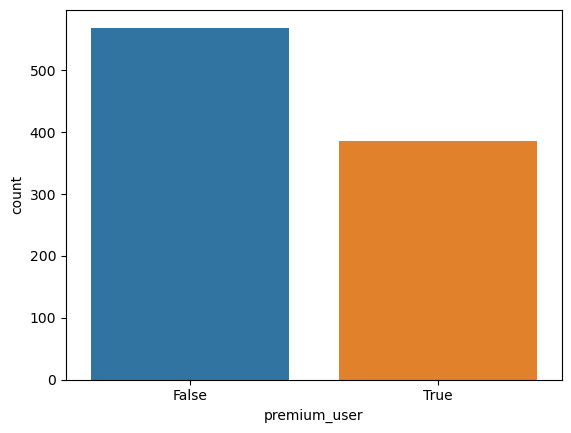

In [4]:
sns.countplot(data=users_df, x='premium_user')


Rozkład ulubionych gatunków muzycznych użytkowników:

<BarContainer object of 50 artists>

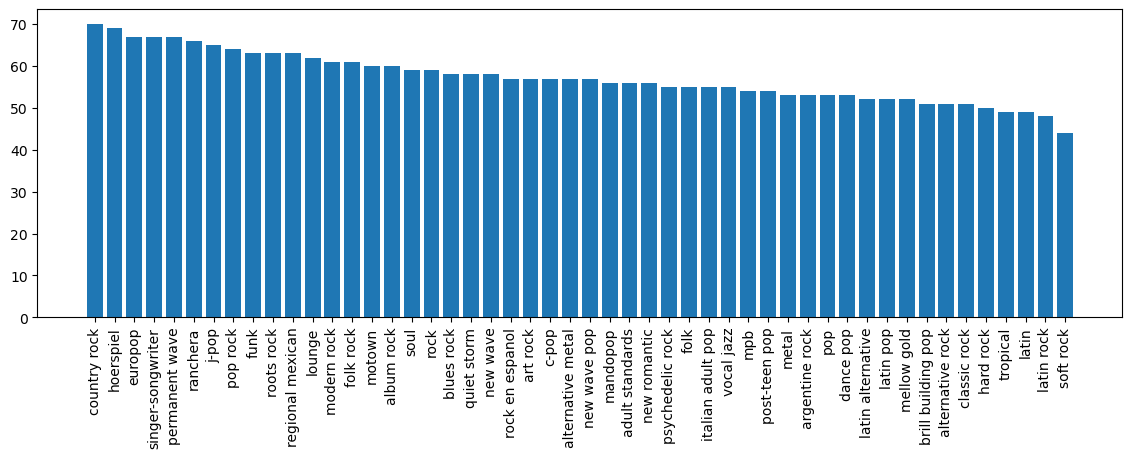

In [5]:
def to_1D(series):
  return pd.Series([x for _list in series for x in _list])

users_df.favourite_genres.fillna('', inplace=True)
unique_values = to_1D(users_df["favourite_genres"]).value_counts().index.tolist()
unique_value_counts = to_1D(users_df["favourite_genres"]).value_counts().values

fig, ax = plt.subplots(figsize = (14,4))
plt.xticks(rotation=90)
ax.bar(unique_values, unique_value_counts)

Rozkład miast użytkowników:

<Axes: xlabel='city', ylabel='count'>

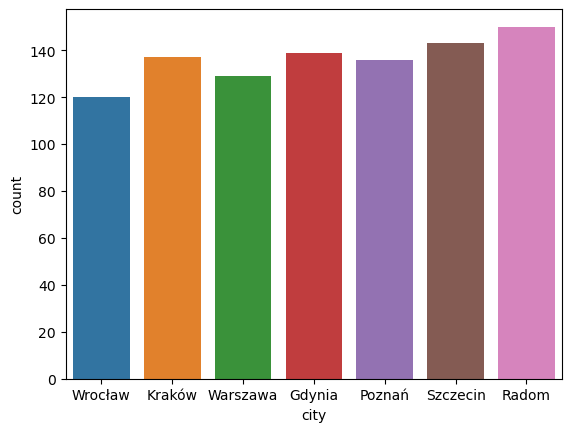

In [6]:
sns.countplot(data=users_df, x='city')

### Plik sessions.json

Sprawdzenie czy w danych istnieją wartości nieokreślone (*null*):

In [7]:
sessions_df.loc[:, 'timestamp'] = pd.to_datetime(sessions_df.loc[:, 'timestamp'])
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484214 entries, 0 to 484213
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   timestamp   484214 non-null  datetime64[ns]
 1   user_id     484214 non-null  int64         
 2   track_id    484214 non-null  object        
 3   event_type  484214 non-null  object        
 4   session_id  484214 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 18.5+ MB


/tmp/ipykernel_29770/2145538459.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sessions_df.loc[:, 'timestamp'] = pd.to_datetime(sessions_df.loc[:, 'timestamp'])


In [8]:
sessions_df.loc[:, 'event_type'].unique()

array(['PLAY', 'LIKE', 'ADVERTISEMENT', 'SKIP', 'BUY_PREMIUM'],
      dtype=object)

Sprawdzenie, czy istnieją sesje o zerowej długości:

In [9]:
sessions_df.sort_values('timestamp', ascending=True, inplace=True)
differences = list()

zero_duration_sessions = 0
for session_id, session in sessions_df.groupby('session_id'):
    sessions_starting_points = session.loc[session.loc[:,'event_type'] == 'PLAY'].reset_index()
    sessions_starting_points['prev_timestamp'] = sessions_starting_points['timestamp'].shift(1)
    
    # Calculate the time difference between consecutive records
    sessions_starting_points['time_diff'] = sessions_starting_points['timestamp'] - sessions_starting_points['prev_timestamp']
    zero_duration_sessions += np.sum(sessions_starting_points['time_diff']==np.timedelta64(0))
    
zero_duration_sessions   

0

In [10]:
event_type_count = sessions_df.groupby(['user_id', 'event_type']).size().unstack(fill_value=0).reset_index()
# rename columns to include event_type_ prefix
event_type_count.columns = ['user_id'] + ['event_type_' + col for col in event_type_count.columns[1:]]
event_type_count.drop("event_type_BUY_PREMIUM", axis='columns', inplace=True)
event_type_count

,user_id,event_type_ADVERTISEMENT,event_type_LIKE,event_type_PLAY,event_type_SKIP
0,101,28,121,344,178
1,102,76,84,327,16
2,103,25,52,160,11
3,104,105,114,381,190
4,105,73,71,306,25
...,...,...,...,...,...
949,1050,43,39,124,64
950,1051,85,54,271,10
951,1052,35,130,366,203
952,1053,102,94,375,29


Sprawdzenie, czy wszyscy użytkownicy z pliku sessions.json są w pliku users.json

In [11]:
assert len([x for x in sessions_df.loc[:, 'user_id'].unique() if x in users_df.loc[:, 'user_id'].unique()]) == len(users_df.loc[:, 'user_id'].unique())

In [12]:
print("First date in the dataset: ", sessions_df.loc[:, "timestamp"].min().strftime("%d/%m/%Y"))
print("Last date in the dataset: ", sessions_df.loc[:, "timestamp"].max().strftime("%d/%m/%Y"))


First date in the dataset:  31/03/2022
Last date in the dataset:  31/03/2023


Wykres ilości kupionych kont premium w kolejnych tygodniach:

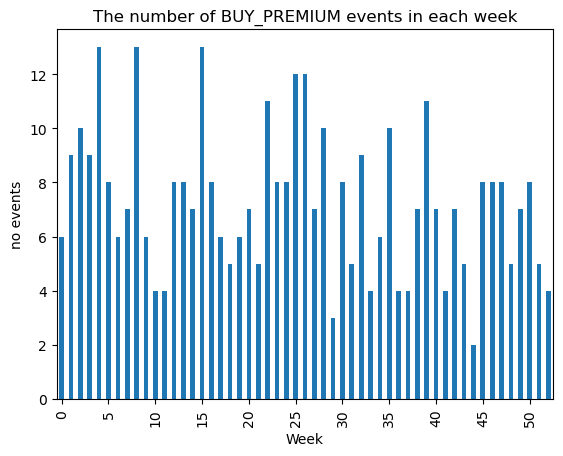

In [13]:
# group by week and count the number of records in each week
weekly_counts = sessions_df[sessions_df['event_type'] == 'BUY_PREMIUM'].groupby(pd.Grouper(freq='W', key="timestamp"))['event_type'].count()
ax = weekly_counts.plot(kind="bar")
ax.set_title("The number of BUY_PREMIUM events in each week")
ax.set_xlabel("Week")
ax.set_ylabel("no events")

ax.set_xticks(range(0, len(weekly_counts), 5))
ax.set_xticklabels(range(0, len(weekly_counts), 5))

plt.show()

## Wnioski

### Pierwsza wersja danych
Do naszych potrzeb najbardziej użyteczne będą pliki *users.json* i *sessions.json*.
Dodatkowo w celu identyfikacji gatunku używane będą pliki *tracks.json* i *artists.json*.

Wspólne defekty danych:
- wiele brakujących wartości (null),
- mała ilość danych,
- niereprezentatywne dane.

Dodatkowo:
1. Plik users.json:
    - Atrybut o nazwie "id" ma niedeskryptywną nazwę oraz jest obecny tylko w kilku próbkach.
    - Brak jednoznacznego oznaczania lokalizacji - aleja -> al., ulica -> ul.

2. Plik sessions.json:
    - Niektóre sesje trwają 0 sekund,
    - Brak wartości "event_type" dla reklam.

### Druga wersja danych

- Dane zostały wyczyszczone - nie ma wartości null,
- danych jest więcej,
- obejmują tylko jeden rok, 
- większosć problemów zaznaczonych przy pierwszej wersji danych została rozwiązana,
- dane są zbilansowane pod względem miejsca zamieszkania i ulubionych gantunków muzycznych użytkowników,
- rozkład zakupu premium w różnych okresach czasu (tygodniach) jest nierównomierny.  

### Model bazowy klasyfikatora

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer


In [15]:
mlb = MultiLabelBinarizer(sparse_output=True)
lb = LabelBinarizer()

users_df = users_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(users_df.pop('favourite_genres')),
                index=users_df.index,
                columns=mlb.classes_))


users_df = users_df.join(
            pd.DataFrame(
                lb.fit_transform(users_df.pop('city')),
                index=users_df.index,
                columns=lb.classes_))

Kontrolne sprawdzenie, czy nie ma wartości null:

In [16]:
assert users_df.isna().sum().sum() == 0


In [17]:
def calculate_ads_time(df):
    ads_mask = df.loc[:,'event_type'] == "ADVERTISEMENT"
    ads_time = np.timedelta64(0)
    for _, action in df.loc[ads_mask].iterrows():
        difference = action.next_timestamp - action.timestamp
        if difference < np.timedelta64(0):
            pass
        ads_time += difference
    return ads_time

Wyznaczanie stosunku między czasem reklam a czasem pozostałych akcji

In [18]:
sessions_filtered = pd.DataFrame()
time_comparison_df = pd.DataFrame()

for user_id, user_actions in sessions_df.groupby('user_id'):
    user_bought_premium = False
    user_ads_time = np.timedelta64(0)
    user_all_time = np.timedelta64(0)
    
    for session_id, session in user_actions.groupby('session_id'):
        if user_bought_premium:
            break

        session.sort_values(by=['timestamp'])
        user_all_time += session.iloc[-1, session.columns.get_loc("timestamp")] - session.iloc[0, session.columns.get_loc("timestamp")]

        premium_bought_mask = session.loc[:,'event_type'] == "BUY_PREMIUM"
        bought_premium_in_session = premium_bought_mask.any()

        if bought_premium_in_session:
            time_of_buy_premium = session.loc[premium_bought_mask].timestamp.iloc[0]
            session = session.loc[session.loc[:, 'timestamp'] <= time_of_buy_premium]
            user_bought_premium = True
        
        sessions_filtered = pd.concat([sessions_filtered, session])
        session.loc[:, 'next_timestamp'] = session.loc[:, 'timestamp'].shift(-1, fill_value=session.loc[:,'timestamp'].max())

        user_ads_time += calculate_ads_time(session)
    
    # ads_time = np.sum((user_actions.loc[ads_mask]["next_timestamp"] - user_actions.loc[ads_mask].index)/ np.timedelta64(1, 's'))
   
    session_times_df = pd.DataFrame(
        {
            'all_time': user_all_time/ np.timedelta64(1, 's'),
            'ads_time': user_ads_time/ np.timedelta64(1, 's'), 
         },
            index=[user_id], 
    )
    time_comparison_df = pd.concat([time_comparison_df, session_times_df])
    

/tmp/ipykernel_29770/1186655351.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.loc[:, 'next_timestamp'] = session.loc[:, 'timestamp'].shift(-1, fill_value=session.loc[:,'timestamp'].max())
/tmp/ipykernel_29770/1186655351.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.loc[:, 'next_timestamp'] = session.loc[:, 'timestamp'].shift(-1, fill_value=session.loc[:,'timestamp'].max())
/tmp/ipykernel_29770/1186655351.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [19]:
users_df = users_df.join(
    pd.DataFrame(data=time_comparison_df.loc[:,'ads_time']/time_comparison_df.loc[:,'all_time'], columns=["Ads_ratio"]),
    on="user_id")


Klasyfikator naiwny

Klasyfikator minimalno-odległościowy jako klasyfikator bazowy

In [20]:
X = users_df.drop(["premium_user", "street", "name", "user_id"], axis=1) 
y = users_df.loc[:, "premium_user"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=18)
kneigh = NearestCentroid()
kneigh.fit(X_train, y_train)

y_hat = kneigh.predict(X_test)
score = accuracy_score(y_test, y_hat)
score 

/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.5206349206349207

In [21]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_hat)
print(report)

              precision    recall  f1-score   support

       False       0.67      0.52      0.59       206
        True       0.37      0.52      0.43       109

    accuracy                           0.52       315
   macro avg       0.52      0.52      0.51       315
weighted avg       0.57      0.52      0.53       315



K najbliższych sąsiadów jako klasyfikator bazowy

In [22]:
X = users_df.drop(["premium_user", "street", "name", "user_id"], axis=1) 
y = users_df.loc[:, "premium_user"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=18)
kneigh = KNeighborsClassifier()
kneigh.fit(X_train, y_train)

y_hat = kneigh.predict(X_test)

score = accuracy_score(y_test, y_hat)
score 

/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.6063492063492063

zapisanie do pliku

In [ ]:
import pickle

filename = 'finalized_kneigh.sav'
pickle.dump(kneigh, open(filename, 'wb'))

Testy AB:

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, fmt="d")
print("f1", f1_score(y_test, y_hat))
plt.show()

In [23]:
report = classification_report(y_test, y_hat)
print(report)

              precision    recall  f1-score   support

       False       0.71      0.67      0.69       206
        True       0.44      0.48      0.46       109

    accuracy                           0.61       315
   macro avg       0.57      0.58      0.57       315
weighted avg       0.61      0.61      0.61       315



Klasyfikator naiwny - klasyfikator zwracający zawsze prawdę.

In [24]:
y_hat = [True for i in range(len(X_test))]
score = accuracy_score(y_test, y_hat)
score

0.346031746031746

In [25]:
report = classification_report(y_test, y_hat)
print(report)

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       206
        True       0.35      1.00      0.51       109

    accuracy                           0.35       315
   macro avg       0.17      0.50      0.26       315
weighted avg       0.12      0.35      0.18       315



/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Wnioski z bazowego modelu predykcyjnego   
- Dokładność klasyfikatora naiwnego odpowiada rozkładowi danych, czyli w tym przypadku, klasyfikując użytkowników jako zawsze skłonnych do kupienia premium, otrzymujemy skuteczność około 35%. Gdybyśmy użyli klasyfikatora naiwnego zwracającego zawsze fałsz, uzyskalibyśmy skuteczność około 65%. Patrząc tylko na skuteczność, oba nasze modele bazowe wypadają gorzej od naiwnego. Uważamy jednak, że skuteczność nie jest jedyną miarą, na podstawie której powinniśmy oceniać model, szczególnie biorąc pod uwagę brak idealnego balansu między klasami - klasyfikator naiwny zawsze będzie działał lepiej przewidując klasę większościową. Innymi pomiarami jakości są między innymi precyzja (precission), czułość (recall) oraz f1-score. Zakładając, że klientowi najbardziej zależy na tym, żeby osoby, którym polecane jest premium rzeczywiscie były zainteresowane jego kupnem, to precission jest wyznacznikiem, który należy brać pod uwagę najbardziej. Wtedy model K najbliższych sąsiadów wypada najlepiej.
- Model K najbliższych sąsiadów poradził sobie lepiej niż klasyfikator minimalno-odległościowy. 
- Może być konieczne stworzenie dodatkowych atrybutów.
- Model do osiągnięcia najlepszych wyników należy dostroić (np. poprzez przeszukiwanie po hipersiatce).

### Estymacja analitycznego kryterium sukcesu
W oparciu o wyniki klasyfikacji modelu K-najbliższych sąsiadów, możemy stwierdzić, że istnieje zależność pomiędzy długością reklam w sesji użytkownika a posiadaniem konta premium.

Dla bazowego modelu, który nie został w żaden sposób dostrojony do problemu, osiągnięto dokładność na poziomie ~60%. Z całej analizy wnioskujemy istnienie wzorców w danych, których głębsze zbadanie wraz z lepszym doborem hiperparametrów pozwoli na zwiększenie skuteczności modelu (liczymy na około 10 punktów procentowych wzrostu).

Dlatego przyjęte analityczne kryterium sukcesu to dokładność predykcji na poziomie 70%.

### Dalsze plany pracy
- zbudowanie bardziej złożonego modelu,
- feature generation
    - dodanie do analizy trendów czasowych - potrzebna kolejna wersja danych, obejmująca więcej niż jeden rok sesji,
    - momenent i częstotliwość pojawiania się reklam w trakcie sesji (np. czy było to przed ulubioną piosenką)
- sprawdzenie korelacji atrybutów, odrzucenie silnie skorelowanych atrybutów.

In [26]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_forest = clf.predict(X_test)

report = classification_report(y_forest, y_hat)
accuracy = accuracy_score(y_forest, y_hat)
print(accuracy)
print(report)

/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.08888888888888889
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       287
        True       0.09      1.00      0.16        28

    accuracy                           0.09       315
   macro avg       0.04      0.50      0.08       315
weighted avg       0.01      0.09      0.01       315



/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-define

In [27]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_tree = clf.predict(X_test)

report = classification_report(y_tree, y_hat)
accuracy = accuracy_score(y_tree, y_hat)
print(accuracy)
print(report)

0.4666666666666667
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       168
        True       0.47      1.00      0.64       147

    accuracy                           0.47       315
   macro avg       0.23      0.50      0.32       315
weighted avg       0.22      0.47      0.30       315



/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa